# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# Project Overview

## Business Goal
Predict which recipes will lead to **high website traffic** when featured on the homepage.
- **Target:** Correctly predict high-traffic recipes ≥ 80% of the time
- **Why it matters:** A popular homepage recipe drives up to 40% more site traffic → more subscriptions

## Metric Strategy
| Context | Metric | Why |
|---|---|---|
| **Internal model comparison** | AUC (ROC) | Threshold-independent; measures ranking quality across all thresholds |
| **Business monitoring & client discussions** | Precision & Recall | Directly interpretable: '84% of homepage recipes drive high traffic' |

## 0. Setup & Import

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)
from scipy import stats

In [14]:
# ── DataCamp Color Palette──────────
DC_GREEN      = '#36D57D'   # Primary brand green
DC_GREEN_DARK = '#1FAD60'   # Green dark variant
DC_NAVY       = '#05192D'   # Primary dark background
DC_NAVY_MID   = '#0F3460'   # Mid navy for secondary elements
DC_ORANGE     = '#FF9400'   # Orange accent
DC_BLUE       = '#06BDFC'   # Blue accent
DC_PURPLE     = '#8468C4'   # Purple accent
DC_LIGHT      = '#F5F9FC'   # Light background
DC_MUTED      = '#69788C'   # Muted text / secondary labels
DC_WHITE      = '#FFFFFF'

# Matplotlib global style — DataCamp-inspired dark-on-light
plt.rcParams.update({
    'figure.dpi':          130,
    'figure.facecolor':    DC_WHITE,
    'axes.facecolor':      DC_LIGHT,
    'axes.edgecolor':      '#D0DCE8',
    'axes.labelcolor':     DC_NAVY,
    'axes.titlecolor':     DC_NAVY,
    'axes.spines.top':     False,
    'axes.spines.right':   False,
    'axes.spines.left':    True,
    'axes.spines.bottom':  True,
    'axes.grid':           True,
    'axes.grid.axis':      'y',
    'grid.color':          '#D0DCE8',
    'grid.linewidth':      0.6,
    'xtick.color':         DC_MUTED,
    'ytick.color':         DC_MUTED,
    'text.color':          DC_NAVY,
    'font.family':         'DejaVu Sans',
    'font.size':           11,
})

SEED = 42
print('✓ Setup complete — DataCamp color theme loaded.')
print(f'  Green: {DC_GREEN}  |  Navy: {DC_NAVY}  |  Orange: {DC_ORANGE}')
print(f'  Blue:  {DC_BLUE}   |  Purple: {DC_PURPLE}')

✓ Setup complete — DataCamp color theme loaded.
  Green: #36D57D  |  Navy: #05192D  |  Orange: #FF9400
  Blue:  #06BDFC   |  Purple: #8468C4


## 1. Data Validation

In [15]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
print(f'Shape: {df.shape}')
df.head()

Shape: (947, 8)


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [17]:
print('=== MISSING VALUES ===')
missing     = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
print(pd.DataFrame({'Missing': missing, 'Missing%': missing_pct}))

=== MISSING VALUES ===
              Missing  Missing%
recipe              0       0.0
calories           52       5.5
carbohydrate       52       5.5
sugar              52       5.5
protein            52       5.5
category            0       0.0
servings            0       0.0
high_traffic      373      39.4


In [18]:
print('recipe — unique:', df['recipe'].nunique(), '| duplicates:', df['recipe'].duplicated().sum())

for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    print(f'{col}: min={df[col].min():.2f}, max={df[col].max():.2f}, '
          f'median={df[col].median():.2f}, missing={df[col].isnull().sum()}')


spec_cats  = {'Lunch/Snacks','Beverages','Potato','Vegetable','Meat',
              'Chicken','Pork','Dessert','Breakfast','One Dish Meal'}
found_cats = set(df['category'].unique())
print(f'\nExpected categories: {sorted(spec_cats)}')
print(f'Found    categories: {sorted(found_cats)}')
print(f'Extra (not in spec): {found_cats - spec_cats}')

print(f'\nservings unique: {df["servings"].unique()}')
print(f'\nhigh_traffic value counts:')
print(df['high_traffic'].value_counts(dropna=False))

recipe — unique: 947 | duplicates: 0
calories: min=0.14, max=3633.16, median=288.55, missing=52
carbohydrate: min=0.03, max=530.42, median=21.48, missing=52
sugar: min=0.01, max=148.75, median=4.55, missing=52
protein: min=0.00, max=363.36, median=10.80, missing=52

Expected categories: ['Beverages', 'Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']
Found    categories: ['Beverages', 'Breakfast', 'Chicken', 'Chicken Breast', 'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']
Extra (not in spec): {'Chicken Breast'}

servings unique: ['6' '4' '1' '2' '4 as a snack' '6 as a snack']

high_traffic value counts:
High    574
NaN     373
Name: high_traffic, dtype: int64


In [20]:
nutrition_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
print('Rows with ALL nutrition missing:', df[nutrition_cols].isnull().all(axis=1).sum())
print('Rows with ANY nutrition missing:', df[nutrition_cols].isnull().any(axis=1).sum())

Rows with ALL nutrition missing: 52
Rows with ANY nutrition missing: 52


Same rows across all nutrition columns — safe to impute with medians.

### 1.1 Cleaning Decisions
| Column | Issue | Decision |
|---|---|---|
| nutrition cols | 52 rows (5.5%) fully missing | Impute with column median |
| `category` | 'Chicken Breast' not in spec (11 vs 10 expected) | Merge into 'Chicken' |
| `servings` | Mixed format: '4 as a snack' | Extract numeric prefix |
| `high_traffic` | NaN = no 'High' label (373 rows) | NaN → 0 (Low); High → 1 |

In [48]:
df_clean = df.copy()

# 1. Fix category
df_clean['category'] = df_clean['category'].replace('Chicken Breast', 'Chicken')
print('Categories after fix:', sorted(df_clean['category'].unique()))

# 2. Fix servings
df_clean['num_servings'] = df_clean['servings'].replace(' as a snack', '', regex=True).astype(float)

# 3. Impute nutrition with medians
nutrition_medians = {}
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    med = df_clean[col].median()
    nutrition_medians[col] = med
    df_clean[col] = df_clean[col].fillna(med)
    print(f'  {col}: imputed {df[col].isnull().sum()} rows → median = {med:.2f}')

# 4. Binary target
df_clean['high_traffic_binary'] = (df_clean['high_traffic'] == 'High').astype(int)
df_clean['high_traffic'].fillna('Low', inplace=True) # just for plots

print(f'\nTarget: {df_clean["high_traffic_binary"].value_counts().to_dict()}')
print(f'High traffic rate: {df_clean["high_traffic_binary"].mean():.1%}')
print(f'Shape after cleaning: {df_clean.shape}')

Categories after fix: ['Beverages', 'Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']
  calories: imputed 52 rows → median = 288.55
  carbohydrate: imputed 52 rows → median = 21.48
  sugar: imputed 52 rows → median = 4.55
  protein: imputed 52 rows → median = 10.80

Target: {1: 574, 0: 373}
High traffic rate: 60.6%
Shape after cleaning: (947, 10)


### Sanity Check & Feature Engineering 

In [25]:
print("no. of records with inaccuracy in macros and calories", 
      (df_clean['calories'] < 4*(df_clean['carbohydrate']+df_clean['protein'])).sum())

no. of records with inaccuracy in macros and calories 324


In [51]:
df_clean['inacc'] = (df_clean['calories'] < 4*(df_clean['carbohydrate']+df_clean['protein']))

Assuming, the same macro's are shown to end-users and made the decision using said macros. Therefore, not changing anything in macros. 

Add inacc feature to incorporate this effect in modeling. 

## EDA

### 3.1 Target Distribution

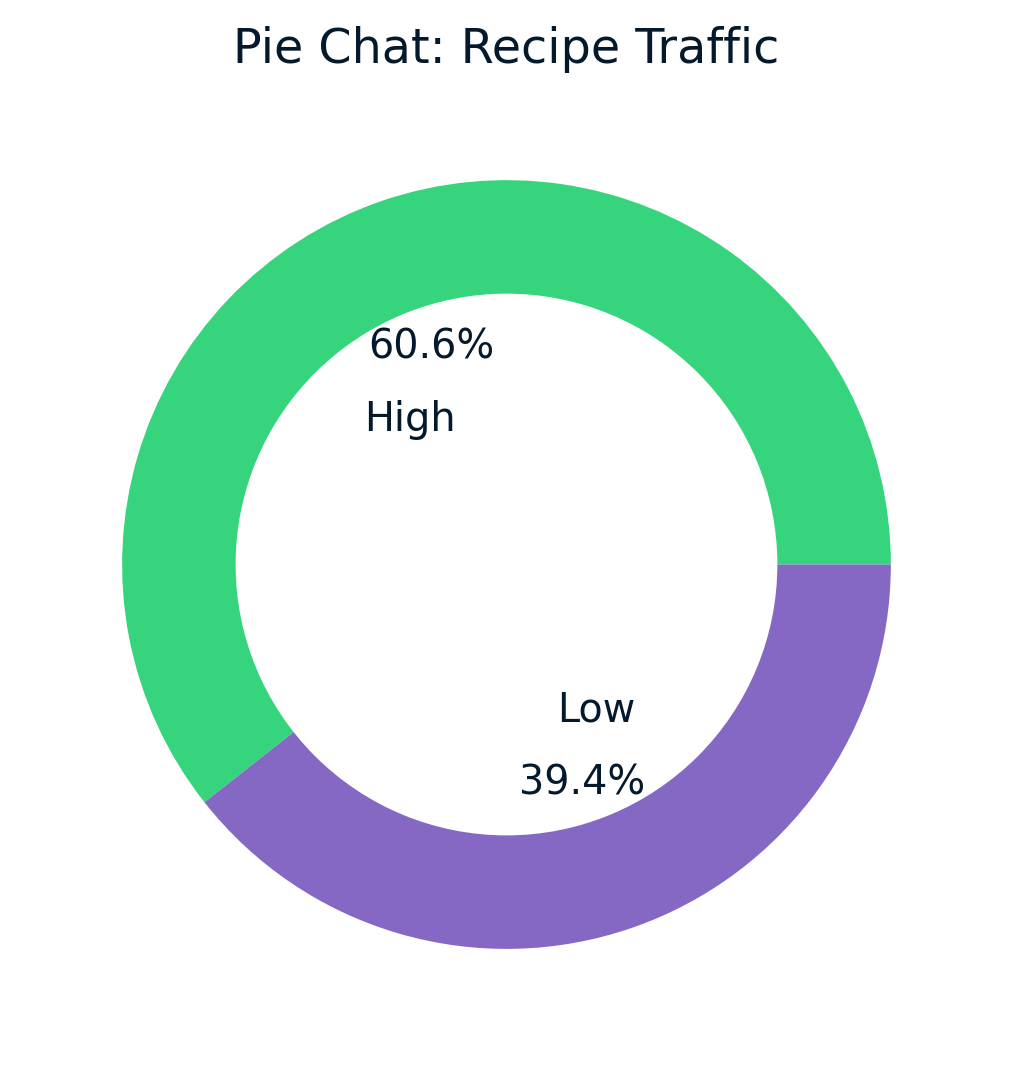

In [38]:
dist = df_clean['high_traffic_binary'].value_counts().values
names = ['High', 'Low']
my_circle = plt.Circle( (0,0), 0.7, color=DC_WHITE)
plt.pie(dist, labels=names, colors=[DC_GREEN, DC_PURPLE], 
        autopct='%1.1f%%', labeldistance=0.40)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Pie Chat: Recipe Traffic")
plt.show()

### 3.2 Categorical Distribution

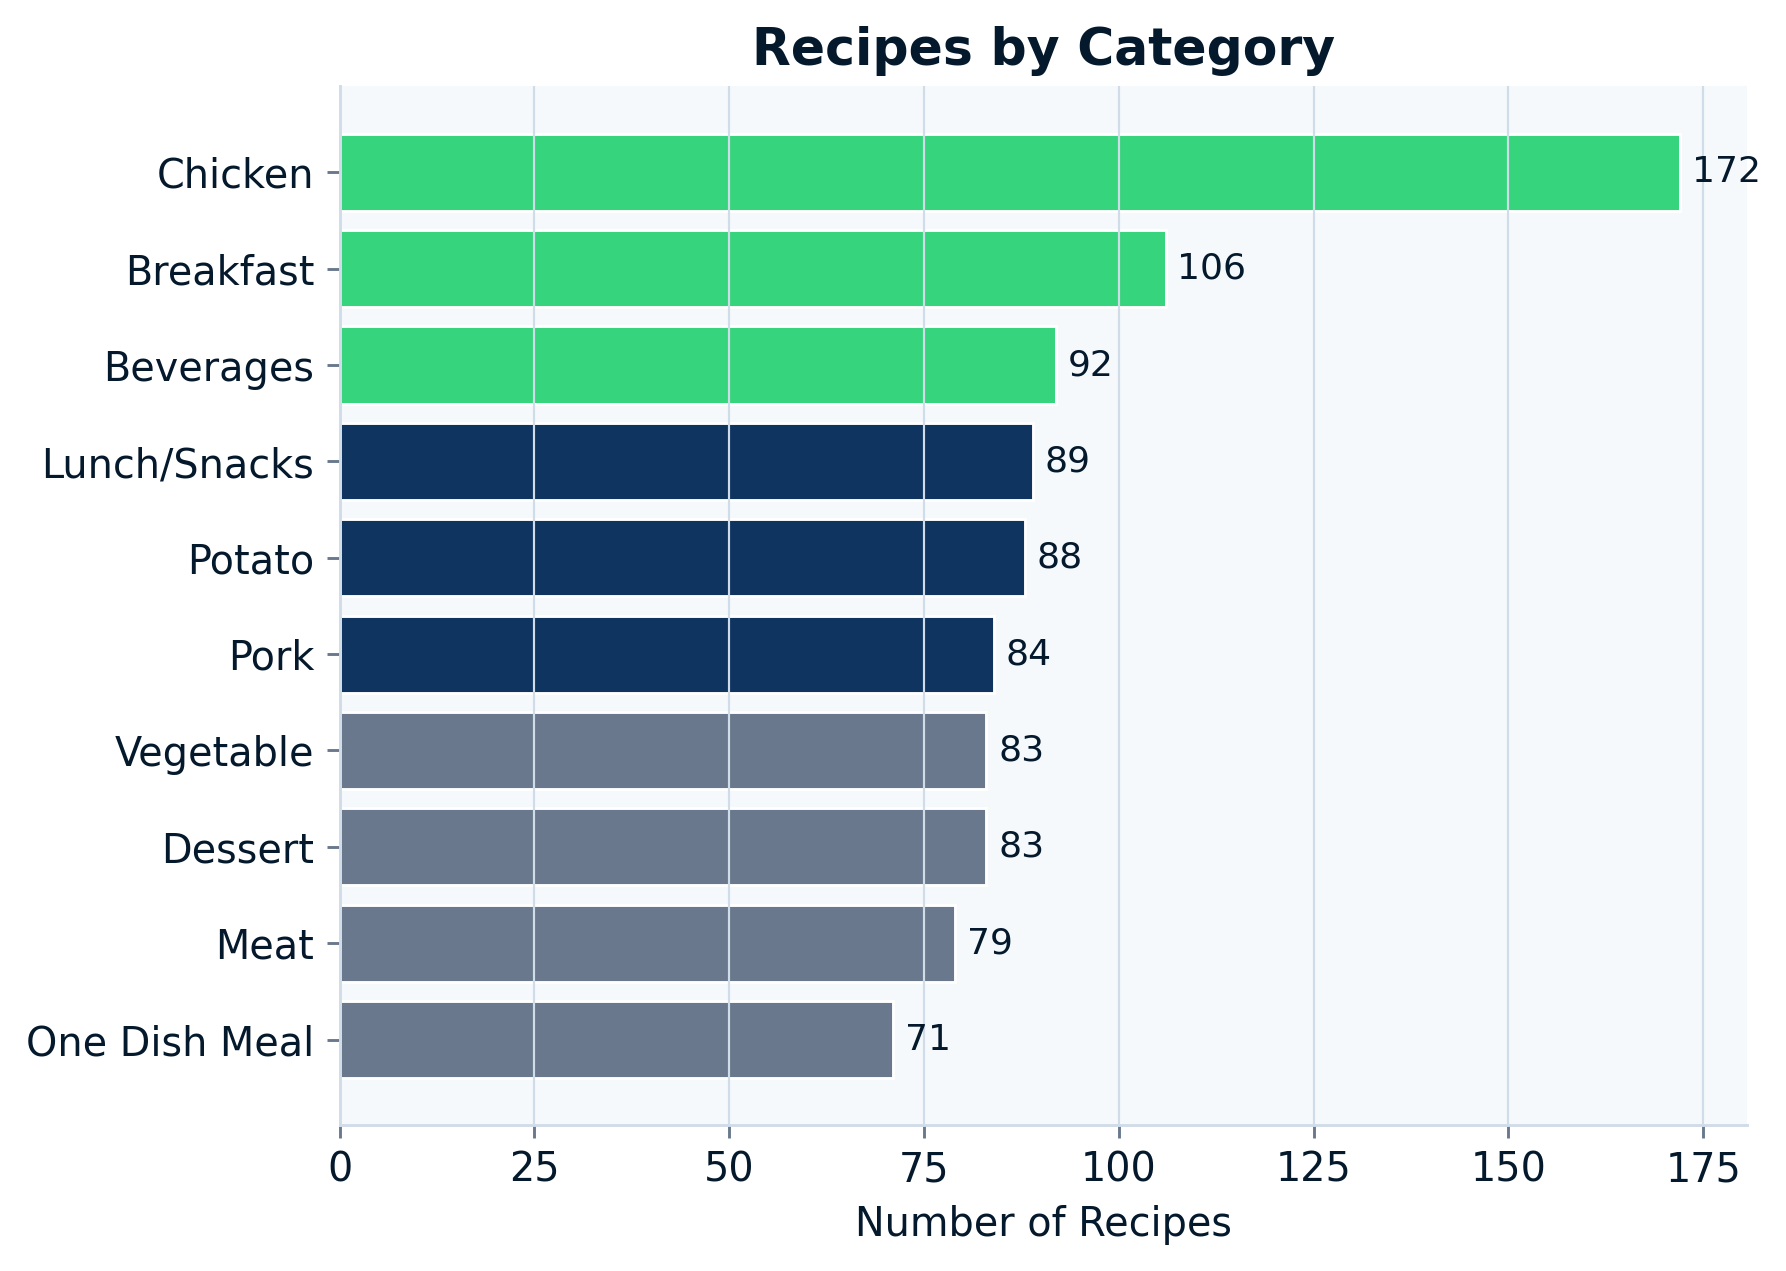

In [40]:
cat_counts = df_clean['category'].value_counts()

fig, ax = plt.subplots(figsize=(7, 5))
# Gradient-style: darker for larger categories
n = len(cat_counts)
bar_colors = [DC_GREEN if i < n//3 else (DC_NAVY_MID if i < 2*n//3 else DC_MUTED)
              for i in range(n)]
ax.barh(cat_counts.index[::-1], cat_counts.values[::-1],
        color=bar_colors[::-1], edgecolor=DC_WHITE, linewidth=0.8)
for i, val in enumerate(cat_counts.values[::-1]):
    ax.text(val + 1.5, i, str(val), va='center', fontsize=10, color=DC_NAVY)
ax.set_title('Recipes by Category', fontsize=14, fontweight='bold', color=DC_NAVY)
ax.set_xlabel('Number of Recipes')
ax.grid(axis='x')
ax.grid(axis='y', visible=False)
fig.tight_layout()
plt.show()

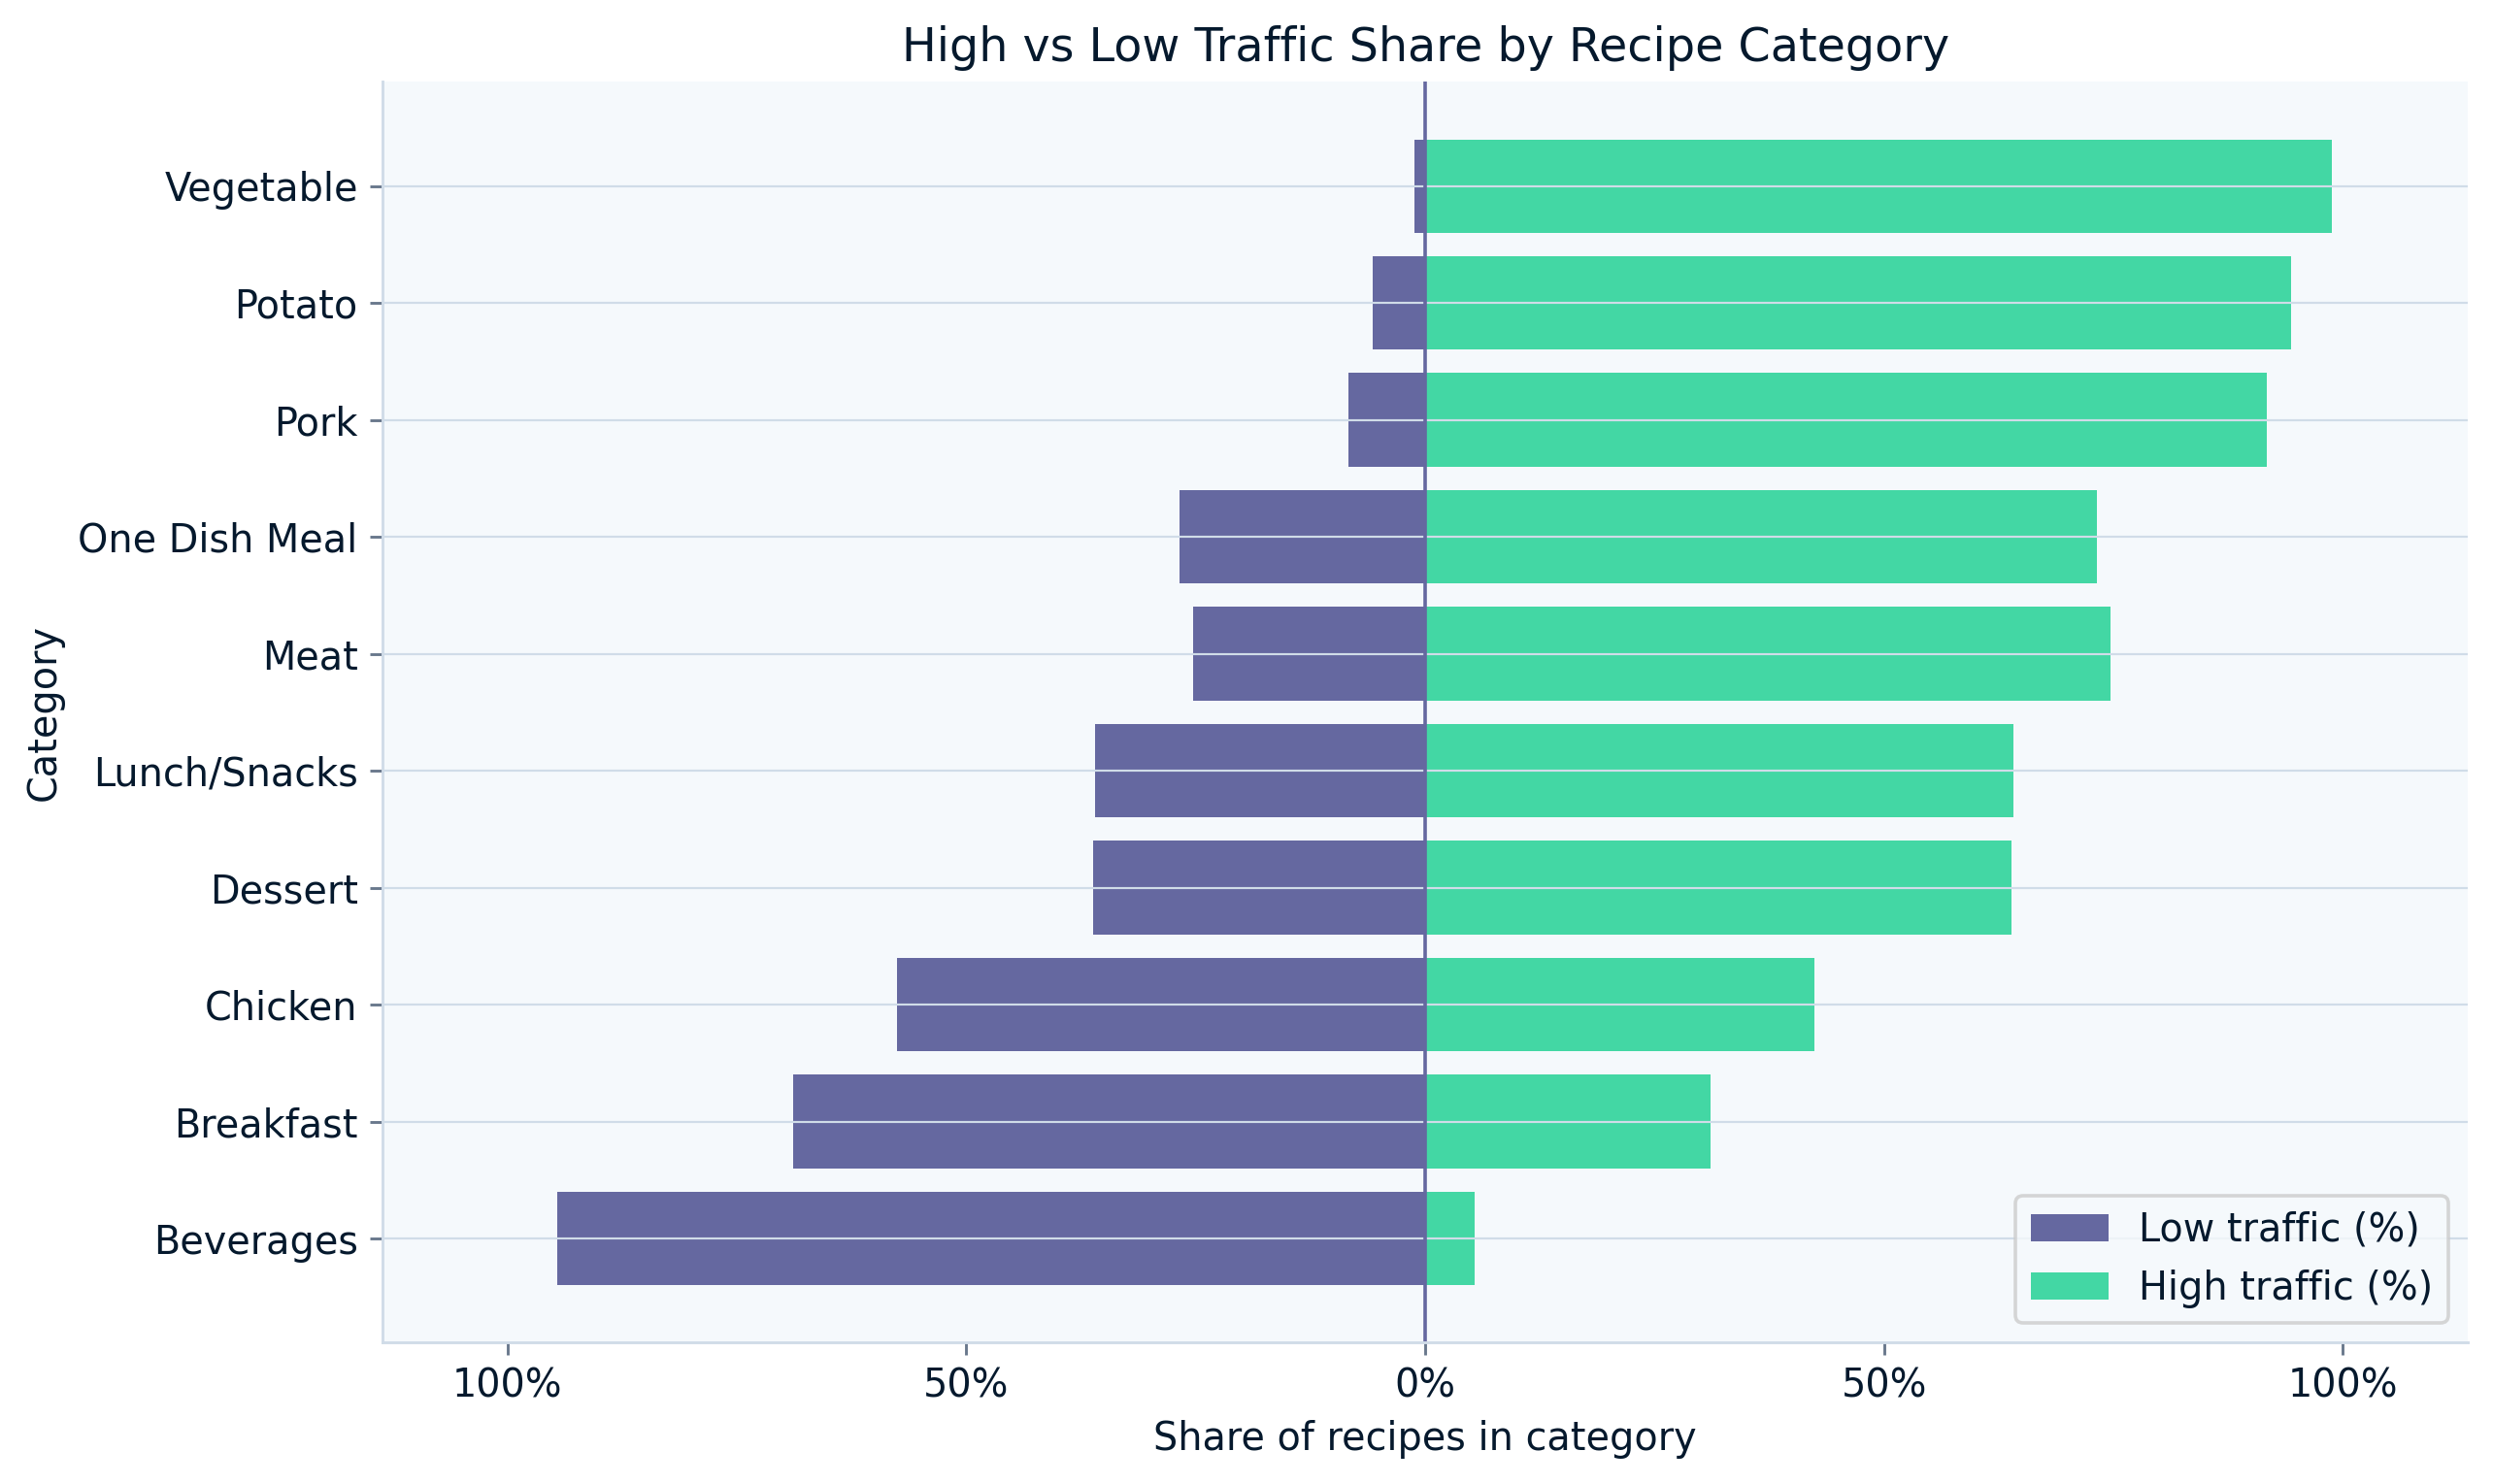

In [44]:
counts = (
    df_clean.groupby(["category", "high_traffic_binary"])
      .size()
      .unstack(fill_value=0)
)

# Ensure both columns exist
for col in [1, 0]:
    if col not in counts.columns:
        counts[col] = 0

share = counts.div(counts.sum(axis=1), axis=0) * 100

low_vals = -share[0].values
high_vals = share[1].values
cats = share.index.astype(str)
y = np.arange(len(cats))

plt.figure(figsize=(10, 6))
plt.barh(y, low_vals, label="Low traffic (%)")
plt.barh(y, high_vals, label="High traffic (%)")

plt.yticks(y, cats)
plt.axvline(0, linewidth=1)

max_abs = max(np.abs(low_vals).max(), np.abs(high_vals).max())
plt.xlim(-max_abs * 1.15, max_abs * 1.15)

xticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f"{abs(t):.0f}%" for t in xticks])

plt.title("High vs Low Traffic Share by Recipe Category")
plt.xlabel("Share of recipes in category")
plt.ylabel("Category")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

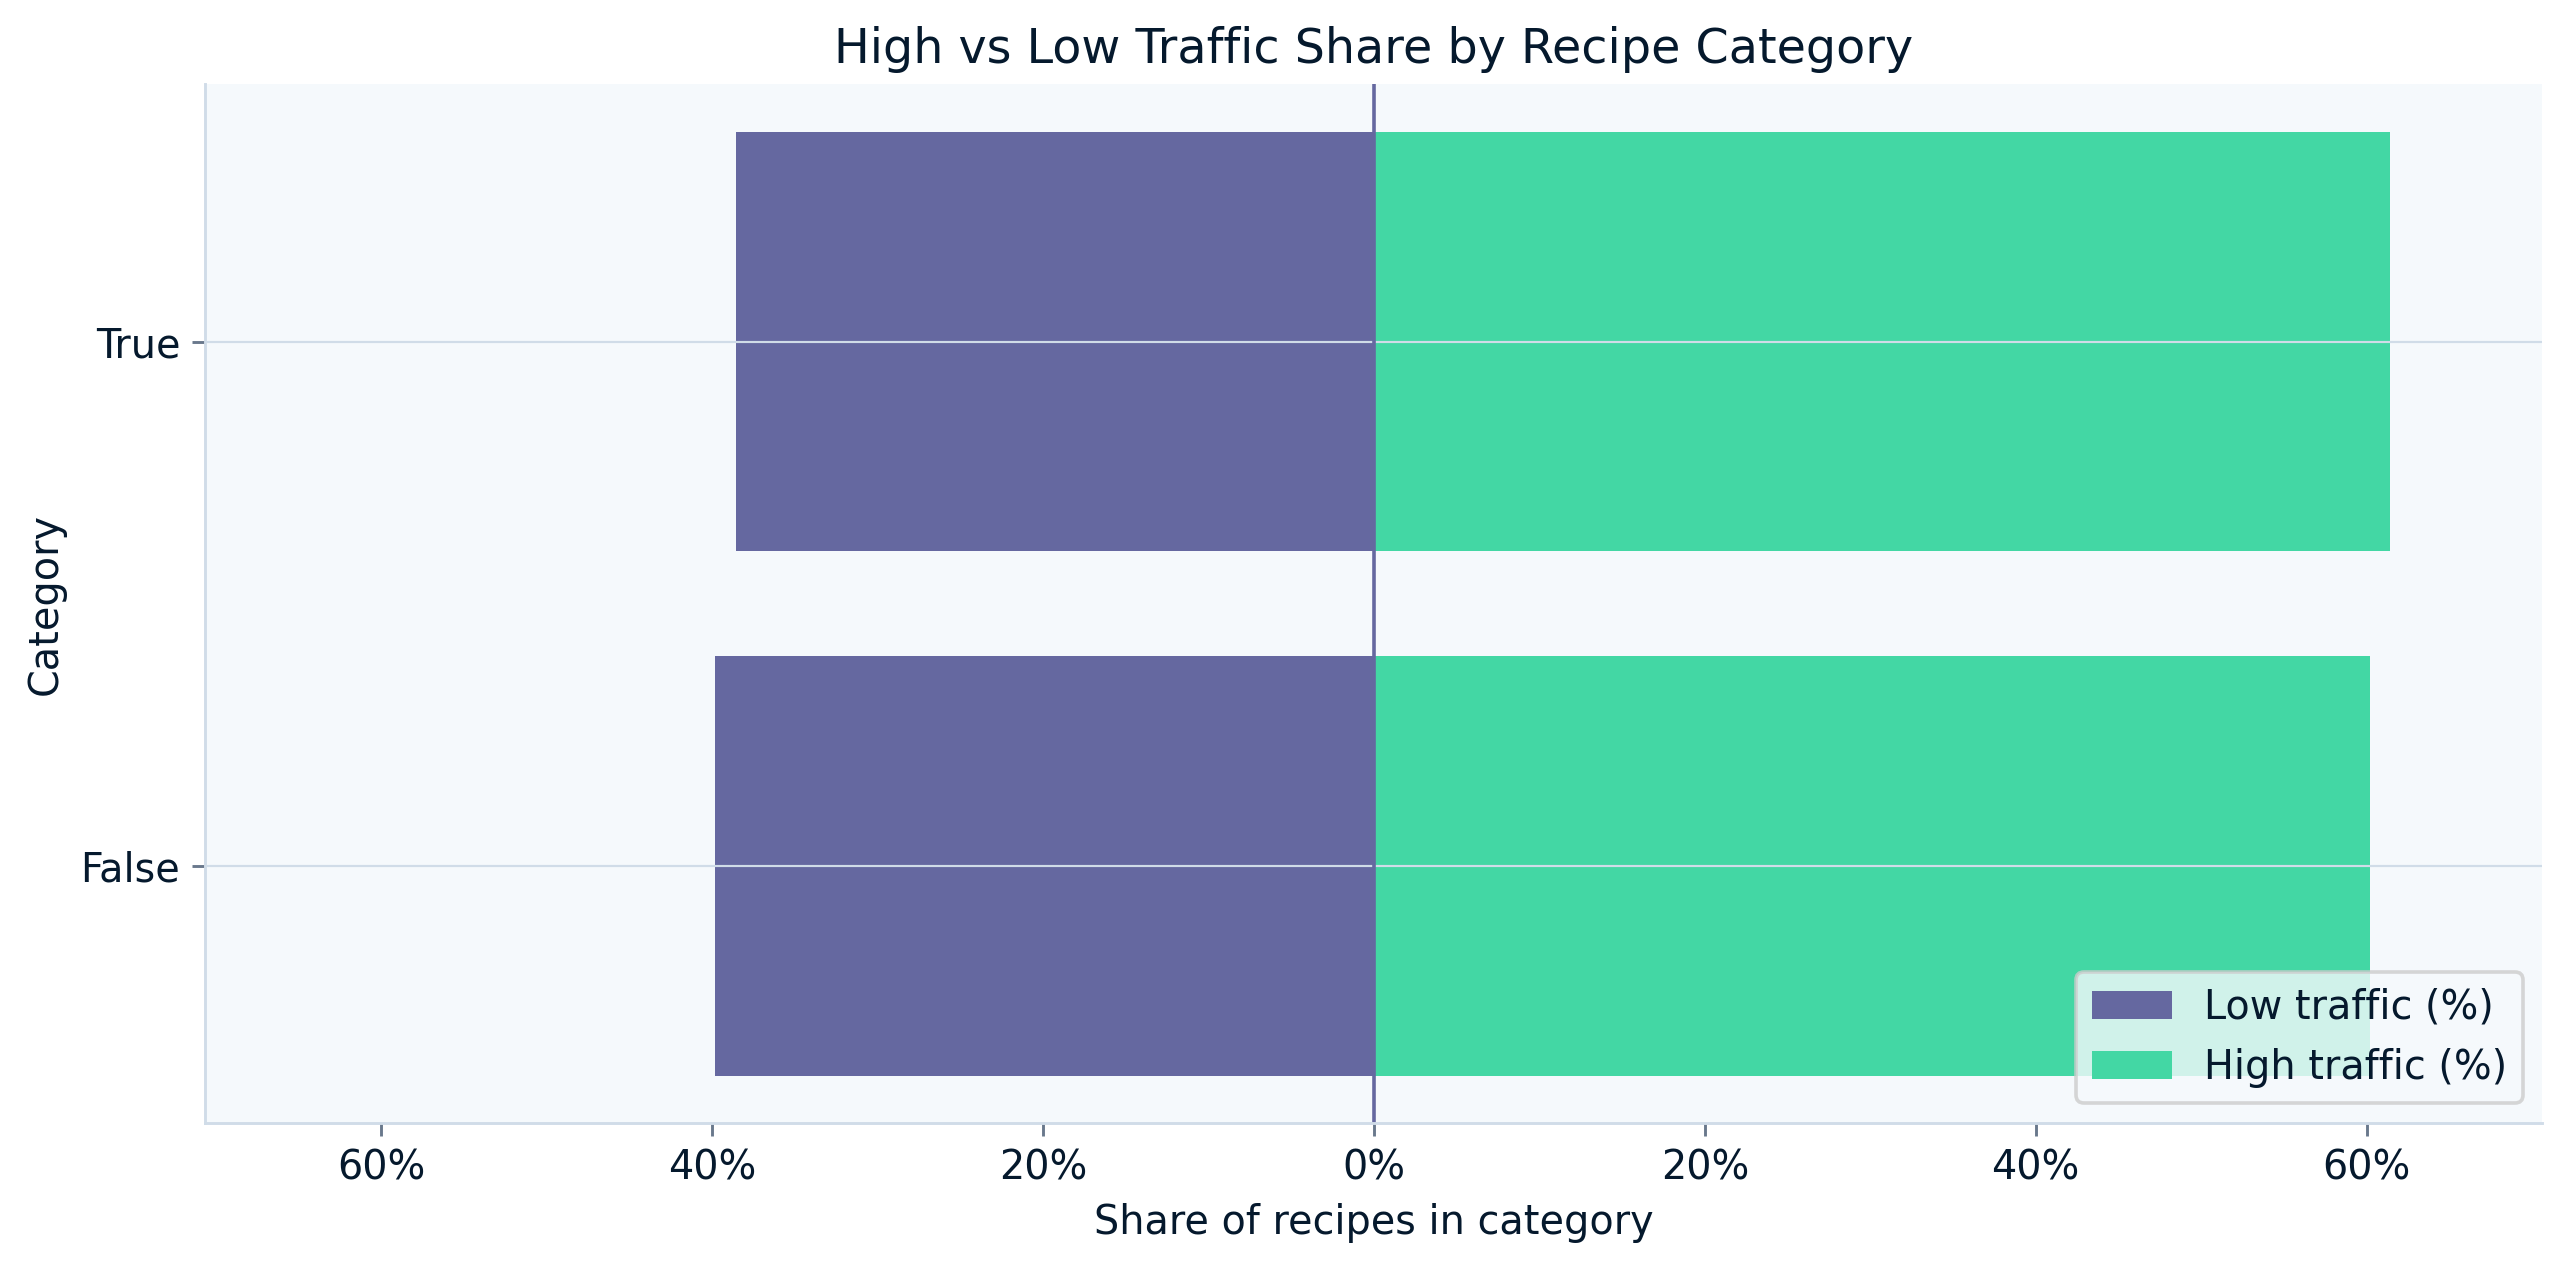

In [55]:
counts = (
    df_clean.groupby(["inacc", "high_traffic_binary"])
      .size()
      .unstack(fill_value=0)
)

# Ensure both columns exist
for col in [1, 0]:
    if col not in counts.columns:
        counts[col] = 0

share = counts.div(counts.sum(axis=1), axis=0) * 100

low_vals = -share[0].values
high_vals = share[1].values
cats = share.index.astype(str)
y = np.arange(len(cats))

plt.figure(figsize=(10, 5))
plt.barh(y, low_vals, label="Low traffic (%)")
plt.barh(y, high_vals, label="High traffic (%)")

plt.yticks(y, cats)
plt.axvline(0, linewidth=1)

max_abs = max(np.abs(low_vals).max(), np.abs(high_vals).max())
plt.xlim(-max_abs * 1.15, max_abs * 1.15)

xticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f"{abs(t):.0f}%" for t in xticks])

plt.title("High vs Low Traffic Share by Recipe Category")
plt.xlabel("Share of recipes in category")
plt.ylabel("Category")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Recipe counts differ by category, this represents the underlying business distribution. 

The observed variation in High-traffic share across categories suggests category is a strong predictive signal and should be preserved in modeling.

In-accuracy does not show strong predictive signal, can be dropped from modeling. 

### 3.3 Numeric Distribution 

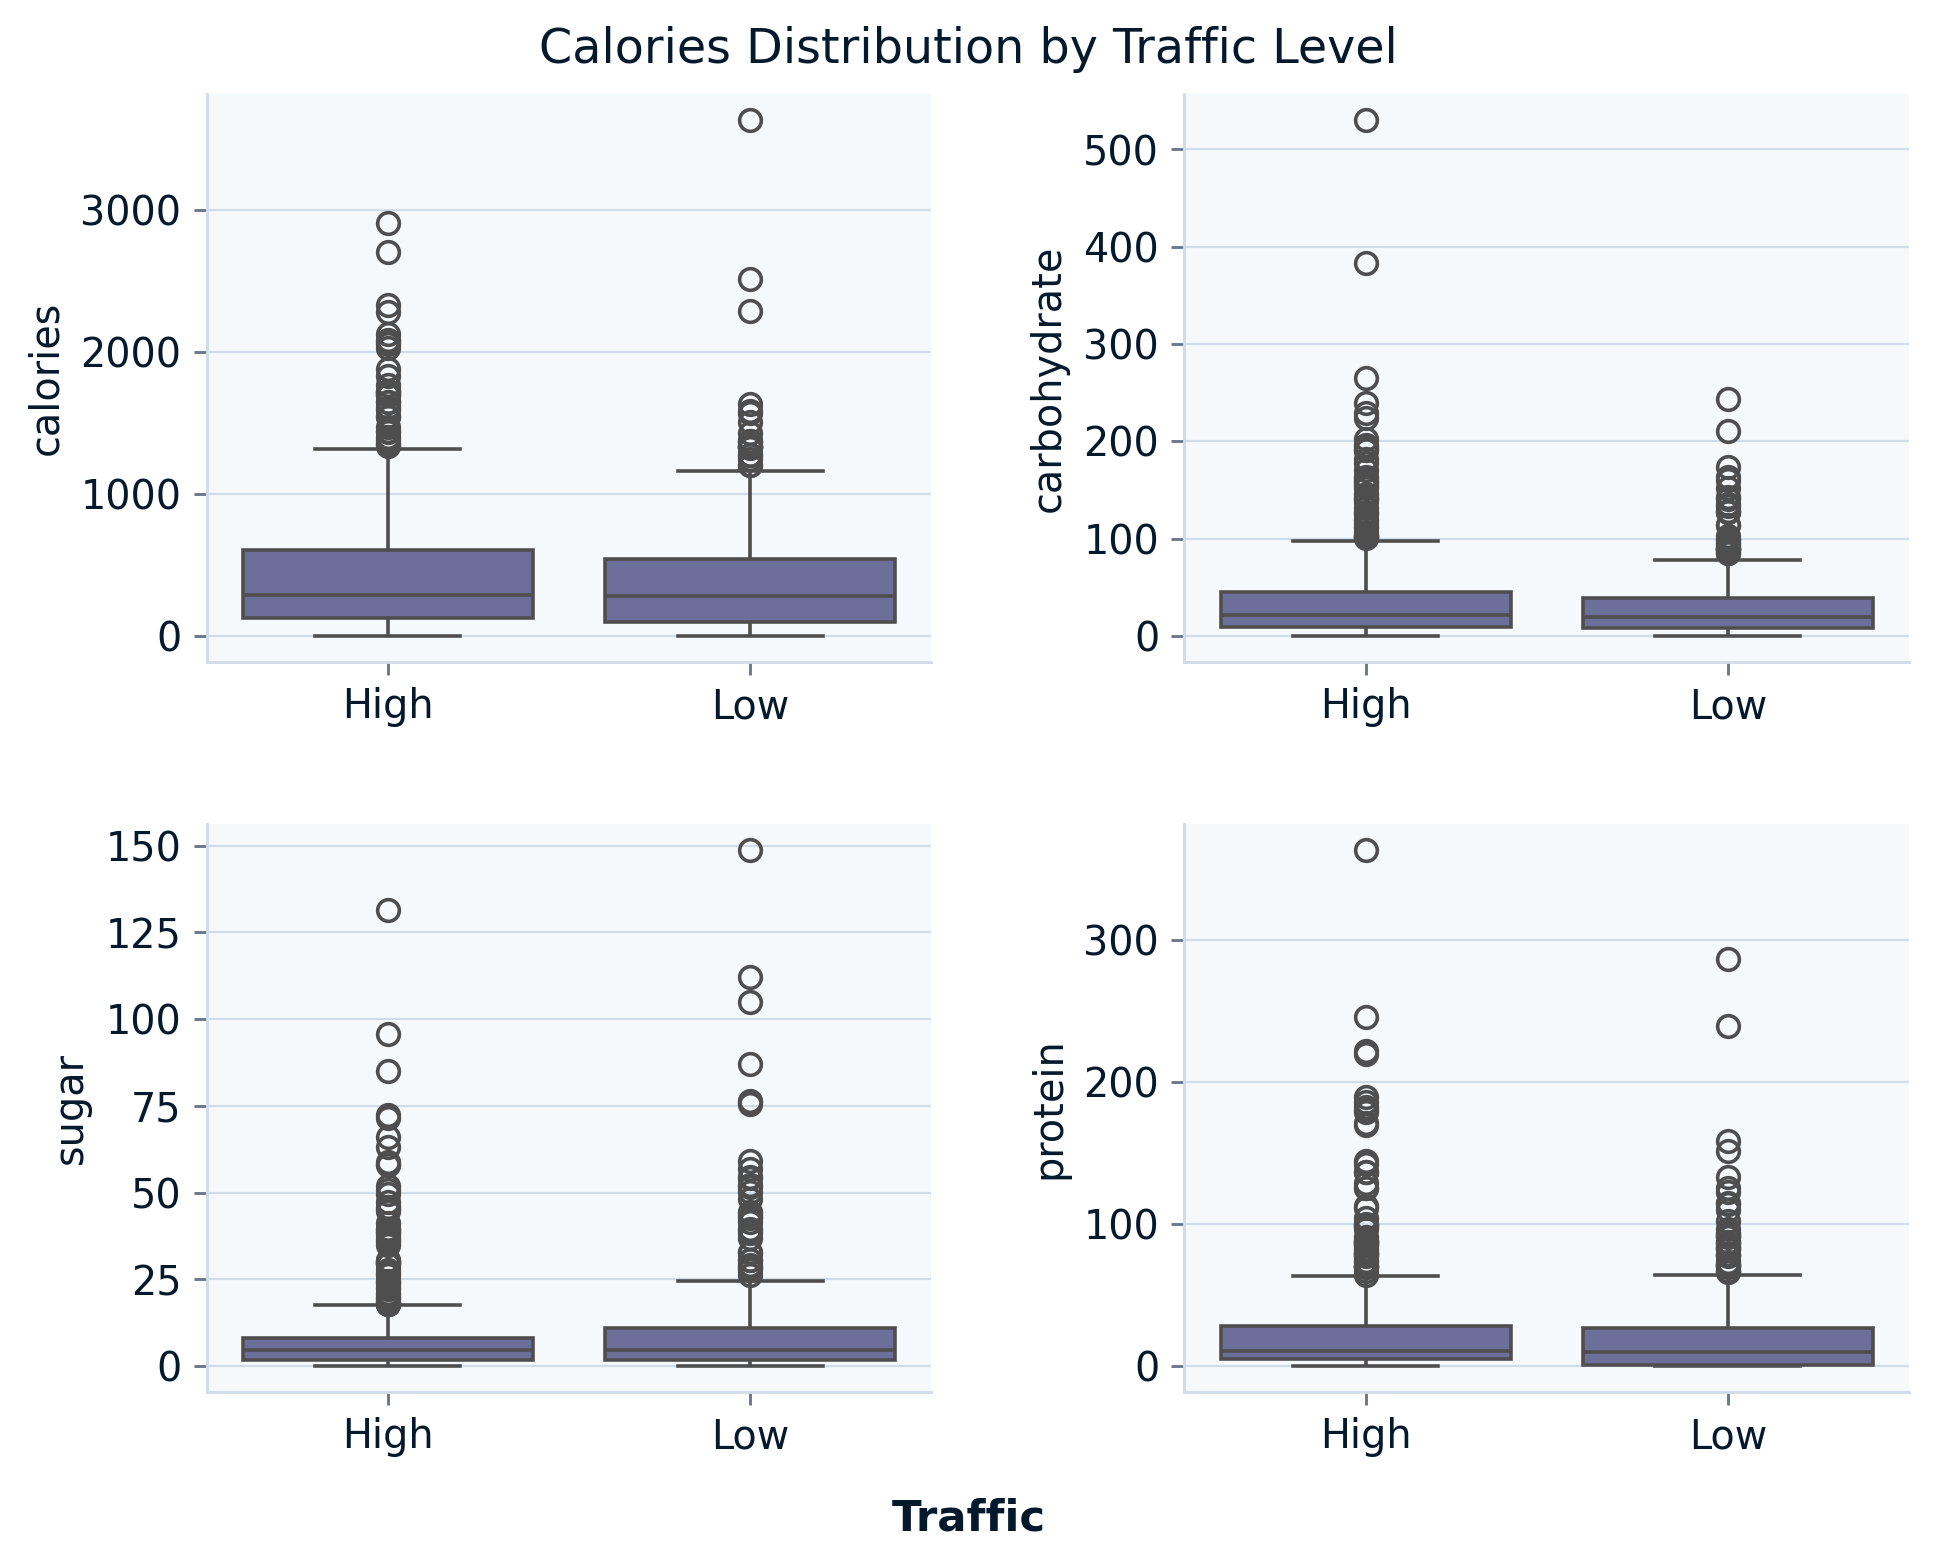

In [64]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
sns.boxplot(data=df_clean, x="high_traffic", y='calories', ax=axs[0,0]).set(xlabel=None)
sns.boxplot(data=df_clean, x="high_traffic", y='carbohydrate', ax=axs[0,1]).set(xlabel=None)
sns.boxplot(data=df_clean, x="high_traffic", y='sugar', ax=axs[1,0]).set(xlabel=None)
sns.boxplot(data=df_clean, x="high_traffic", y='protein', ax=axs[1,1]).set(xlabel=None)
plt.tight_layout(pad=2.5)
plt.suptitle("Calories Distribution by Traffic Level")
fig.supxlabel('Traffic', fontsize=12, fontweight='bold')
plt.show()

Nutritional features (calories, carbohydrate, sugar, protein) show substantial overlap between High and Low traffic recipes, suggesting weak standalone discriminatory power. 

These variables may still contribute through interaction effects but are unlikely to be strong primary drivers.

## 4.0 Feature Engineering - Interaction Effect

In [70]:
# user prefer good or balanced macro/ratio based meal
# ex; sugar-heavy vs carb-heavy may matter, or high protein per calorie

df_clean["protein_per_calorie"] = df_clean["protein"] / (df_clean["calories"] + 1e-6)
df_clean["carb_per_calorie"] = df_clean["carbohydrate"] / (df_clean["calories"] + 1e-6)
df_clean["sugar_ratio"] = df_clean["sugar"] / (df_clean["carbohydrate"] + 1e-6)

In [69]:
# acro and calorie concious users
df_clean["macro_balance"] = df_clean["protein"] / (df_clean["protein"] + df_clean["carbohydrate"] + df_clean["sugar"] + 1e-6)
df_clean["calorie_density"] = df_clean["calories"] / (df_clean["num_servings"] + 1e-6)

In [ ]:
!git add notebook.ipynb
!git commit -m "Add interaction effect of nutritional data"
!git push origin master

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation